# Base Matrix Factorisation

In [ ]:
# import modules
import numpy as np
import matplotlib.pyplot as plt
import torch
from tdc.multi_pred import DTI
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import CountVectorizer
import logging
from rdkit import Chem

# load in the three datasets
data_Kd = DTI(name = 'BindingDB_Kd')
data_Kd.convert_to_log(form = 'binding')

data_ic50 = DTI(name = 'BindingDB_IC50')
data_ic50.convert_to_log(form = 'binding')

data_Ki = DTI(name = 'BindingDB_Ki')
data_Ki.convert_to_log(form = 'binding')

In [4]:
def data_split(data):
    # split data and get ID dicts
    split = data.get_split(seed = 42,  frac = [0.6, 0.05, 0.35])
    train = split['train']
    test = split['test']

    train = train[['Drug_ID', 'Drug', 'Target', 'Y']].dropna()
    train = train.reset_index(drop=True)

    ID_to_Drug = dict(enumerate(list(dict.fromkeys(train['Drug_ID']))))
    ID_to_Target = dict(enumerate(list(dict.fromkeys(train['Target']))))
    Drug_to_ID = dict((v,k) for k,v in ID_to_Drug.items())
    Target_to_ID = dict((v,k) for k,v in ID_to_Target.items())
    
    return train, test, Drug_to_ID, Target_to_ID

def data_loader(data, drug_dict, target_dict):
    # load data into correct format
    data["Target_ID2"] = data["Target"].apply(lambda x:target_dict.get(x))
    data["Drug_ID2"] = data["Drug_ID"].apply(lambda x:drug_dict.get(x))
    data = data.dropna()

    drug_ID = data["Drug_ID2"].to_numpy()
    target_ID = data["Target_ID2"].to_numpy()
    features = np.vstack((drug_ID, target_ID)).T
    label = data['Y'].to_numpy()
    return features, label

class RatingDataset(Dataset):
    def __init__(self, train, label):
        self.feature_= train
        self.label_= label
    def __len__(self):
    #return size of dataset
        return len(self.feature_)
    def __getitem__(self, idx):
        return  torch.tensor(self.feature_[idx], dtype=torch.long),torch.tensor(self.label_[idx], dtype=torch.float)
    
    
class MatrixFactorization(torch.nn.Module):
    
    def __init__(self, n_users, n_items, n_factors):
        super().__init__()
        self.user_factors = torch.nn.Embedding(n_users, n_factors)
        self.item_factors = torch.nn.Embedding(n_items, n_factors)
        torch.nn.init.xavier_uniform_(self.user_factors.weight)
        torch.nn.init.xavier_uniform_(self.item_factors.weight)
        
        self.user_biases = torch.nn.Embedding(n_users, 1)
        self.item_biases = torch.nn.Embedding(n_items,1)
        self.user_biases.weight.data.fill_(0.)
        self.item_biases.weight.data.fill_(0.)

        
    def forward(self, user, item):  
        pred = self.user_biases(user) + self.item_biases(item)
        pred += (self.user_factors(user) * self.item_factors(item)).sum(1, keepdim=True)
        return pred.squeeze()

In [13]:
def train_model(train_loader, test_loader, model, num_epochs=100):
    dev = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
    loss_func = torch.nn.MSELoss()
    
    model.to(dev)
    
    train_losses = []
    test_losses = []
    for epoch in range(0,num_epochs):
        count = 0
        cum_loss = 0.
        for i, (train_batch, label_batch) in enumerate(train_loader):
            count = 1 + i
            # Predict and calculate loss for user factor and bias
            optimizer = torch.optim.SGD([model.user_biases.weight,model.user_factors.weight], lr=0.05, weight_decay=1e-5)
            prediction = model(train_batch[:,0].to(dev), train_batch[:,1].to(dev))
            loss = loss_func(prediction, label_batch.to(dev)).float()    
            # Backpropagate
            loss.backward()

            # Update the parameters
            optimizer.step()
            optimizer.zero_grad()

            # predict and calculate loss for item factor and bias
            optimizer = torch.optim.SGD([model.item_biases.weight,model.item_factors.weight], lr=0.05, weight_decay=1e-5)             
            prediction = model(train_batch[:,0].to(dev), train_batch[:,1].to(dev))
            loss = loss_func(prediction, label_batch.to(dev))
            loss_item = loss.item()
            cum_loss += loss_item


            # Backpropagate
            loss.backward()

            # Update the parameters
            optimizer.step()
            optimizer.zero_grad()
        train_loss = cum_loss/count
        train_losses.append(train_loss)

        cum_loss =0.
        count = 0
        for i, (test_batch, label_batch) in enumerate(test_loader):
            count = 1 + i
            with torch.no_grad():
                prediction = model(test_batch[:,0].to(dev), test_batch[:,1].to(dev))
                loss = loss_func(prediction, label_batch.to(dev))
                cum_loss += loss.item()

        test_loss = cum_loss/count
        test_losses.append(test_loss)
        if epoch % 20 == 0:
            print('epoch: ', epoch ,' avg training loss: ', train_loss, ' avg test loss: ',test_loss)
    return train_losses, test_losses

In [14]:
def full_model(data, img_name, n_factors=100, bs=100, num_epochs=100):
    train, test, drug_dict, target_dict = data_split(data)
    x_train, y_train = data_loader(train, drug_dict, target_dict)
    x_test, y_test = data_loader(test, drug_dict, target_dict)

    train_dataloader = DataLoader(RatingDataset(x_train, y_train), batch_size=bs, shuffle=True)
    test_dataloader = DataLoader(RatingDataset(x_test, y_test), batch_size=bs)
    
    model = MatrixFactorization(len(drug_dict), len(target_dict), n_factors)

    train_losses, test_losses = train_model(train_dataloader, test_dataloader, model, num_epochs)

    epochs = range(1, num_epochs+1)
    plt.plot(epochs, train_losses, label='train')
    plt.plot(epochs, test_losses, label='test')
    plt.xlabel('epoch')
    plt.ylabel('mse loss')
    plt.legend()
    plt.title(img_name)
#     plt.savefig(img_name)
    plt.show()

epoch:  0  avg training loss:  26.660169303796852  avg test loss:  16.174788652147566
epoch:  20  avg training loss:  4.053772947590822  avg test loss:  2.5281133719852993
epoch:  40  avg training loss:  2.409251198267481  avg test loss:  1.6172241172620228
epoch:  60  avg training loss:  1.7407010565897463  avg test loss:  1.3006984106131962
epoch:  80  avg training loss:  1.3414458771040485  avg test loss:  1.1238634309598379
epoch:  100  avg training loss:  1.0726482408821203  avg test loss:  1.0215022231851305
epoch:  120  avg training loss:  0.8781888982292952  avg test loss:  0.9637112534471921
epoch:  140  avg training loss:  0.735542641228931  avg test loss:  0.927587346306869
epoch:  160  avg training loss:  0.6282894065140918  avg test loss:  0.9034077904054096
epoch:  180  avg training loss:  0.5468460564875299  avg test loss:  0.8872638006295477
epoch:  200  avg training loss:  0.4824781197651177  avg test loss:  0.8768188791615622
epoch:  220  avg training loss:  0.4316732

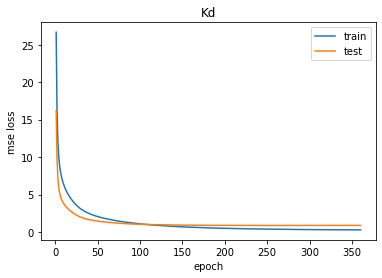

In [9]:
full_model(data_Kd, 'Kd', n_factors=20, bs=100, num_epochs=360)

In [17]:
full_model(data_Ki, 'Ki', n_factors=20, bs=100, num_epochs=260)

In [16]:
full_model(data_ic50, 'ic50', n_factors=20, bs=100, num_epochs=260)